# Pre-trained

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.models.video import s3d
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import torch
from torchvision import transforms
from PIL import Image
import datetime as dt

In [62]:
# Function to load video frames without transformations
def load_video_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    success, frame = cap.read()
    while success:
        # Convert BGR (OpenCV format) to RGB
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        # Convert NumPy array to PIL image
        frames.append(Image.fromarray(frame))
        success, frame = cap.read()
    cap.release()
    return frames  # Return the list of PIL images


# Save pretrained model
def save_pretrained(model):
    date_time_format = '%Y-%m-%d-%H-%M-%S'
    current_date_time_dt = dt.datetime.now()
    current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
    model_name = f'{current_date_time_string}-pretrained-model.pt'
    save_path = f'../models/pretrained/{model_name}'

    torch.save(model.state_dict(), save_path)

    print(f"Saved model to {save_path}")


# Load pretrained model 
def load_pretrained(model, model_path, check_weights=False):
    trained_model = model.load_state_dict(torch.load(model_path, weights_only=True))

    print(f'Loaded model from {model_path}')

    # Check weights
    if check_weights:
        for var_name in model.state_dict():
            print(var_name, "\t", model.state_dict()[var_name])

    return trained_model


# Function to train the model
def train_model(device, model, train_loader, criterion, optimizer, num_epochs=5):
    trained_model = model.train()
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        print("")
        print("Training")
        print("")
        
        count = 1

        for videos, labels in train_loader:
            print(f'{count}/{len(train_loader)}')
            videos, labels = videos.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(videos)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
            count += 1

        count = 1
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}, Accuracy: {100 * correct / total}%")

    save_pretrained(trained_model)


# Function to test the model and return predictions and true labels
def evaluate_model(device, model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for videos, labels in loader:
            videos, labels = videos.to(device), labels.to(device)
            outputs = model(videos)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)


# Function to plot confusion matrix
def plot_confusion_matrix(true_labels, preds, classes):
    cm = confusion_matrix(true_labels, preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()


In [64]:
max_frames = 100  # Set your desired fixed number of frames

class CustomVideoDataset(datasets.DatasetFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        frames = self.loader(path)  # Load frames as PIL images
        frames = [transform(frame) for frame in frames]  # Apply transformations here

        # Limit to max_frames
        if len(frames) > max_frames:
            frames = frames[:max_frames]
        else:
            # If there are fewer frames, pad with zeros
            frames += [torch.zeros_like(frames[0])] * (max_frames - len(frames))

        # Stack the frames
        video_tensor = torch.stack(frames)


        video_tensor = video_tensor.permute(1, 0, 2, 3)
        video_tensor = video_tensor.unsqueeze(0)

        return video_tensor.squeeze(0), target


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define transformations for video frames
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Using device: cuda


In [65]:
# Load train and test datasets using DatasetFolder
train_dir = '../downloads/train'
test_dir = '../downloads/test'

train_dataset = CustomVideoDataset(root=train_dir, loader=load_video_frames, extensions=('mp4',))
test_dataset = CustomVideoDataset(root=test_dir, loader=load_video_frames, extensions=('mp4',))

# Create data loaders as before
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Load pre-trained S3D model and modify the classifier
# model = s3d(pretrained=True)
model = s3d(weights='KINETICS400_V1')
# Access the classifier layers
dropout = model.classifier[0]  # Keep the dropout layer
num_ftrs = model.classifier[1].in_channels  # Get the number of input channels to the Conv3d layer

# Replace the last Conv3d layer with a new one that has the correct number of output classes
model.classifier = nn.Sequential(
    dropout,
    nn.Conv3d(num_ftrs, len(train_dataset.classes), kernel_size=(1, 1, 1))  # Modify for dataset's number of classes
)

model = model.to(device)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [66]:
# Train the model
train_model(device, model, train_loader, criterion, optimizer, num_epochs=5)


Training

Loss: 0.026044807263783047
Loss: 0.042454605656010766
Loss: 0.053764035659176965
Loss: 0.07086705416440964
Loss: 0.0990410755787577
Loss: 0.12125177575009209
Loss: 0.14296613527195795
Loss: 0.1689647404210908
Loss: 0.1761614137462207
Loss: 0.1839656164603574


KeyboardInterrupt: 

In [ ]:
# Load model
model_dir = '../models/pretrained'
model_name = '2024-09-30-15-03-38-pretrained-model.pt'
model_path = f'{model_dir}/{model_name}'
load_pretrained(model, model_path)

In [ ]:
# Evaluate on testing data
test_preds, test_labels = evaluate_model(device, model, test_loader)

In [ ]:
plot_confusion_matrix(test_labels, test_preds, test_dataset.classes)

#### No need to plot confusion for training data

In [8]:
# Evaluate on training data
# train_preds, train_labels = evaluate_model(device, model, train_loader)

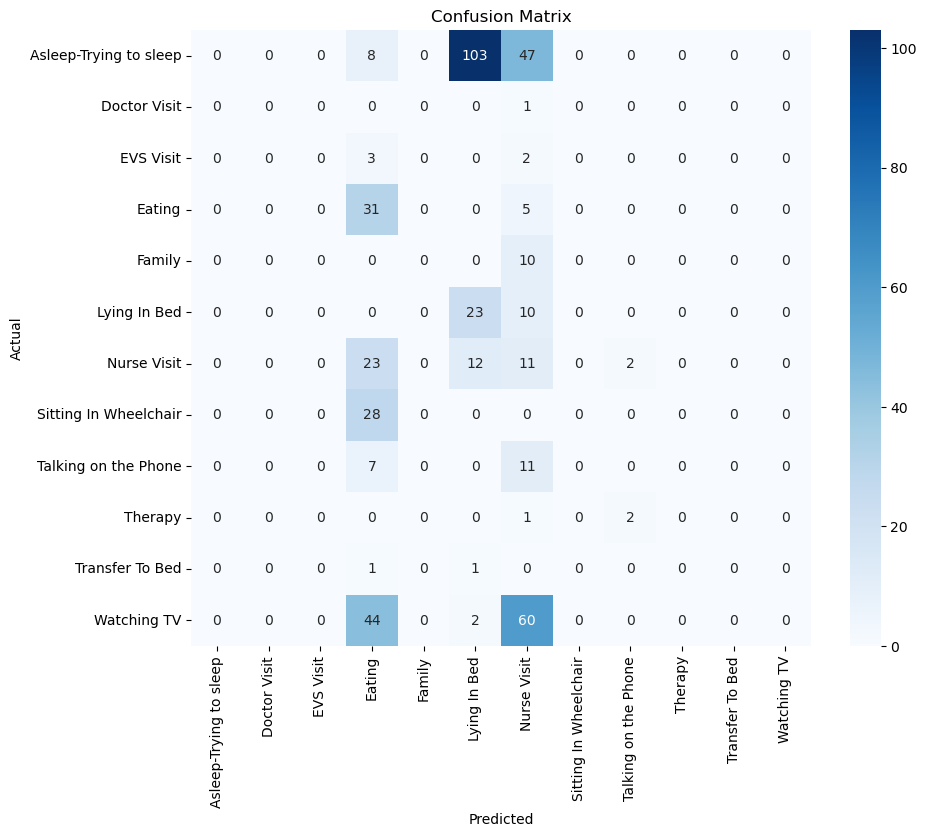

In [9]:
# Plot confusion matrix
# plot_confusion_matrix(train_labels, train_preds, train_dataset.classes)